# settings

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
scalograms_single directory exists

2 dirs and 0 images in "scalograms_single".
2 dirs and 0 images in "scalograms_single/train".
0 dirs and 238 images in "scalograms_single/train/1".
0 dirs and 403 images in "scalograms_single/train/0".
2 dirs and 0 images in "scalograms_single/test".
0 dirs and 66 images in "scalograms_single/test/1".
0 dirs and 106 images in "scalograms_single/test/0".
scalograms_single/train scalograms_single/test

im path: scalograms_single/train/0/410__1_0.png
im class: 0
im height: 64
im width: 101


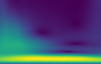

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import scipy.signal as sp
from matplotlib import pyplot as plt
import numpy as np

import os
os.chdir('/content/drive/MyDrive/thesis')
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import scipy.signal as sp
import numpy as np
from matplotlib import pyplot as plt

import pywt
import random

import sys
from pathlib import Path
from tqdm import tqdm

import pandas as pd
import pickle
import joblib
from PIL import Image

import torch
import torchvision
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

image_path = Path('scalograms_single')

if image_path.is_dir():
    print(f'{image_path} directory exists')
else:
    print(f'{image_path} directory doesnt exist')

print()
def walk_through_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f'{len(dirnames)} dirs and {len(filenames)} images in "{dirpath}".')
walk_through_dir(image_path)

train_dir = image_path / 'train'
test_dir = image_path / 'test'

print(train_dir, test_dir)
print()

image_path_list = list(image_path.glob('*/*/*.png'))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f'im path: {random_image_path}')
print(f'im class: {image_class}')
print(f'im height: {img.height}')
print(f'im width: {img.width}')
img

In [ ]:
img.size

(99, 64)

# transforms, datasets and dataloaders

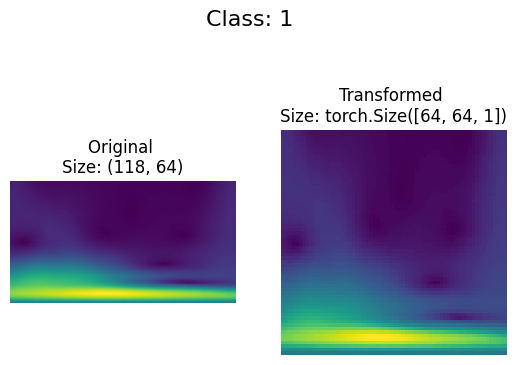

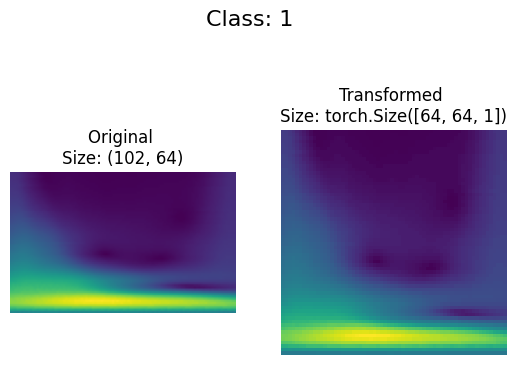

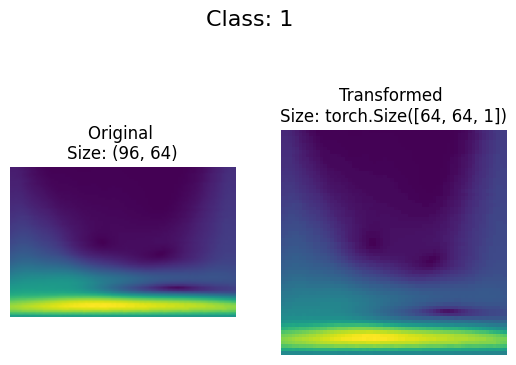

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 16

data_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])
data_transform_test = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
])

def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
    return transformed_image

tr_im = plot_transformed_images(image_path_list, transform=data_transform, n=3)

In [ ]:
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform_test)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 641
    Root location: scalograms_single/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 172
    Root location: scalograms_single/test
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [ ]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.2157, 0.2118, 0.1961,  ..., 0.2275, 0.2353, 0.2353],
         [0.2157, 0.2157, 0.2039,  ..., 0.2235, 0.2314, 0.2353],
         [0.2157, 0.2157, 0.2078,  ..., 0.2196, 0.2314, 0.2353],
         ...,
         [0.6667, 0.6745, 0.6784,  ..., 0.7294, 0.7216, 0.7137],
         [0.5922, 0.5961, 0.6039,  ..., 0.6235, 0.6275, 0.6118],
         [0.4588, 0.4588, 0.4588,  ..., 0.4627, 0.4627, 0.4627]]])
Image shape: torch.Size([1, 64, 64])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


In [ ]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True, drop_last=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False, drop_last=True) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e859f1ba500>,
 <torch.utils.data.dataloader.DataLoader at 0x7e859f1bb250>)

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([16, 1, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([16])


# train/validation functions

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

# baseline model

## definition

In [ ]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=1, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=2, bias=True)
  )
)

## training and validation

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=1, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6678 | train_acc: 0.6156 | test_loss: 0.6390 | test_acc: 0.6625
Epoch: 2 | train_loss: 0.6640 | train_acc: 0.6297 | test_loss: 0.6444 | test_acc: 0.6625
Epoch: 3 | train_loss: 0.6610 | train_acc: 0.6297 | test_loss: 0.6413 | test_acc: 0.6625
Epoch: 4 | train_loss: 0.6620 | train_acc: 0.6281 | test_loss: 0.6513 | test_acc: 0.6625
Epoch: 5 | train_loss: 0.6623 | train_acc: 0.6281 | test_loss: 0.6405 | test_acc: 0.6625
Total training time: 25.847 seconds


# transfer learning

## again prepare transforms/datasets/dataloaders

In [ ]:
auto_transforms

ImageClassification(
    crop_size=[480]
    resize_size=[480]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
weights = torchvision.models.EfficientNet_V2_M_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
auto_transforms = weights.transforms()

train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=auto_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=auto_transforms)


train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True, drop_last=True) # shuffle the data?
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False, drop_last=True) # don't usually need to shuffle testing data

weights = torchvision.models.EfficientNet_V2_M_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_v2_m(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth
100%|██████████| 208M/208M [00:02<00:00, 101MB/s]


## freeze some layers and change head

In [ ]:
for name, param in model.named_parameters():
    if 'features.8' not in name and 'features.7' not in name and 'features.6' not in name and 'classifier' not in name:
        print('freeze', name)


freeze features.0.0.weight
freeze features.0.1.weight
freeze features.0.1.bias
freeze features.1.0.block.0.0.weight
freeze features.1.0.block.0.1.weight
freeze features.1.0.block.0.1.bias
freeze features.1.1.block.0.0.weight
freeze features.1.1.block.0.1.weight
freeze features.1.1.block.0.1.bias
freeze features.1.2.block.0.0.weight
freeze features.1.2.block.0.1.weight
freeze features.1.2.block.0.1.bias
freeze features.2.0.block.0.0.weight
freeze features.2.0.block.0.1.weight
freeze features.2.0.block.0.1.bias
freeze features.2.0.block.1.0.weight
freeze features.2.0.block.1.1.weight
freeze features.2.0.block.1.1.bias
freeze features.2.1.block.0.0.weight
freeze features.2.1.block.0.1.weight
freeze features.2.1.block.0.1.bias
freeze features.2.1.block.1.0.weight
freeze features.2.1.block.1.1.weight
freeze features.2.1.block.1.1.bias
freeze features.2.2.block.0.0.weight
freeze features.2.2.block.0.1.weight
freeze features.2.2.block.0.1.bias
freeze features.2.2.block.1.0.weight
freeze featu

In [ ]:
for name, param in model.named_parameters():
    if 'features.8' not in name and 'features.7' not in name and 'features.6' not in name and 'features.5' not in name and 'classifier' not in name:
        param.requires_grad = False

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = 2

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

## training and validation


In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 15

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=3e-4)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6799 | train_acc: 0.5906 | test_loss: 0.6520 | test_acc: 0.6625
Epoch: 2 | train_loss: 0.6555 | train_acc: 0.6297 | test_loss: 0.6469 | test_acc: 0.6750
Epoch: 3 | train_loss: 0.6520 | train_acc: 0.6250 | test_loss: 0.6422 | test_acc: 0.6687
Epoch: 4 | train_loss: 0.6457 | train_acc: 0.6344 | test_loss: 0.6339 | test_acc: 0.6750
Epoch: 5 | train_loss: 0.6468 | train_acc: 0.6234 | test_loss: 0.6408 | test_acc: 0.6625
Epoch: 6 | train_loss: 0.6338 | train_acc: 0.6438 | test_loss: 0.6327 | test_acc: 0.6562
Epoch: 7 | train_loss: 0.6289 | train_acc: 0.6594 | test_loss: 0.6315 | test_acc: 0.6687
Epoch: 8 | train_loss: 0.6393 | train_acc: 0.6297 | test_loss: 0.6233 | test_acc: 0.6562
Epoch: 9 | train_loss: 0.6305 | train_acc: 0.6609 | test_loss: 0.6222 | test_acc: 0.6562
Epoch: 10 | train_loss: 0.6404 | train_acc: 0.6375 | test_loss: 0.6205 | test_acc: 0.6562


KeyboardInterrupt: 

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 15

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7039 | train_acc: 0.5781 | test_loss: 0.6673 | test_acc: 0.6625
Epoch: 2 | train_loss: 0.6692 | train_acc: 0.6109 | test_loss: 0.6271 | test_acc: 0.6625
Epoch: 3 | train_loss: 0.6654 | train_acc: 0.6125 | test_loss: 0.6370 | test_acc: 0.6625
Epoch: 4 | train_loss: 0.6854 | train_acc: 0.6172 | test_loss: 0.6257 | test_acc: 0.6625


KeyboardInterrupt: 

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 8

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-3, momentum=0.9)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6436 | train_acc: 0.6234 | test_loss: 0.6302 | test_acc: 0.6625
Epoch: 2 | train_loss: 0.6134 | train_acc: 0.6703 | test_loss: 0.6255 | test_acc: 0.6937
Epoch: 3 | train_loss: 0.5847 | train_acc: 0.6594 | test_loss: 0.6223 | test_acc: 0.6687
Epoch: 4 | train_loss: 0.5407 | train_acc: 0.7266 | test_loss: 0.6436 | test_acc: 0.6500
Epoch: 5 | train_loss: 0.4694 | train_acc: 0.7812 | test_loss: 0.6839 | test_acc: 0.6625
Epoch: 6 | train_loss: 0.3904 | train_acc: 0.8484 | test_loss: 0.7334 | test_acc: 0.6000
Epoch: 7 | train_loss: 0.3104 | train_acc: 0.8578 | test_loss: 0.8674 | test_acc: 0.6125
Epoch: 8 | train_loss: 0.2456 | train_acc: 0.8969 | test_loss: 0.9778 | test_acc: 0.5938
Total training time: 359.991 seconds


In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 15

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=1e-3, momentum=0.9)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_results = train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4557 | train_acc: 0.7906 | test_loss: 0.7234 | test_acc: 0.5625
Epoch: 2 | train_loss: 0.3523 | train_acc: 0.8688 | test_loss: 0.7664 | test_acc: 0.6438
Epoch: 3 | train_loss: 0.2978 | train_acc: 0.8859 | test_loss: 0.7795 | test_acc: 0.6000
Epoch: 4 | train_loss: 0.2016 | train_acc: 0.9328 | test_loss: 0.9453 | test_acc: 0.6188
Epoch: 5 | train_loss: 0.1395 | train_acc: 0.9516 | test_loss: 1.0867 | test_acc: 0.5938
Epoch: 6 | train_loss: 0.1009 | train_acc: 0.9703 | test_loss: 1.1831 | test_acc: 0.6000
Epoch: 7 | train_loss: 0.0977 | train_acc: 0.9688 | test_loss: 1.2639 | test_acc: 0.6312
Epoch: 8 | train_loss: 0.1176 | train_acc: 0.9625 | test_loss: 1.3589 | test_acc: 0.6000
Epoch: 9 | train_loss: 0.1053 | train_acc: 0.9594 | test_loss: 1.1900 | test_acc: 0.6438
Epoch: 10 | train_loss: 0.0874 | train_acc: 0.9656 | test_loss: 1.2646 | test_acc: 0.6750
Epoch: 11 | train_loss: 0.0636 | train_acc: 0.9812 | test_loss: 1.3514 | test_acc: 0.6125
Epoch: 12 | train_l

# Save final model

In [ ]:
torch.save(model, 'efficientnet-medium.pt')